In [1]:
from torchvision import datasets
from torchvision import transforms
import groundingdino.datasets.transforms as T
import torchvision
import os
from torch.utils.data import DataLoader
from lang_sam import LangSAM
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
import json
from tqdm import tqdm
import lang_sam.utils as utils
from PIL import Image
from segment_anything.utils.transforms import ResizeLongestSide

/home/amin/miniconda3/envs/lsa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!echo $CUDA_VISIBLE_DEVICES

In [3]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)
def get_phrases_from_posmap(
    posmap, tokenized, tokenizer, left_idx=0, right_idx= 255
):
    assert isinstance(posmap, torch.Tensor), "posmap must be torch.Tensor"
    if posmap.dim() == 1:
        posmap[0: left_idx + 1] = False
        posmap[right_idx:] = False
        non_zero_idx = posmap.nonzero(as_tuple=True)[0].tolist()
        token_ids = [tokenized["input_ids"][i] for i in non_zero_idx]
        return tokenizer.decode(token_ids)
    else:
        raise NotImplementedError("posmap must be 1-dim")

def post_process(outputs,texts,idx,box_threshold=0.3,text_threshold=0.25,W=1200,H=800):
  prediction_logits = outputs["pred_logits"][idx][None].cpu().sigmoid()[0]  # prediction_logits.shape = (nq, 256)
  prediction_boxes = outputs["pred_boxes"][idx][None].cpu()[0]  # prediction_boxes.shape = (nq, 4)
  mask = prediction_logits.max(dim=1)[0] > box_threshold
  logits = prediction_logits[mask]  # logits.shape = (n, 256)
  boxes = prediction_boxes[mask]  # boxes.shape = (n, 4)
  boxes = box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
  tokenizer = model.groundingdino.tokenizer
  tokenized = tokenizer(texts[idx])
  phrases = [
              get_phrases_from_posmap(logit > text_threshold, tokenized, tokenizer).replace('.', '')
              for logit
              in logits
          ]
  return boxes, logits.max(dim=1)[0], phrases

In [5]:
model = LangSAM()

final text_encoder_type: bert-base-uncased


Model loaded from /home/amin/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [6]:
H,W=512,512
transform_gdino= transforms.Compose([
        transforms.Resize((H,W)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        # Initializing Captcha Dataset class
        super(CustomDataset, self).__init__()
        self.root=root
        self.files = sorted(os.listdir(root))
        self.images = []
        self.captions = []
        self.transform=transform
        self.img_ids=[]
        for file in tqdm(self.files):
          img_id=file.split(".")[0]
          caption=". ".join(img_id.split("_"))+"."
          self.img_ids.append(img_id)
          self.images.append(os.path.join(self.root, file))
          self.captions.append(self.preprocess_caption(caption))
          

    def __len__(self):
        # Returning the total number of images
        return len(self.captions)
    def preprocess_caption(self,caption):
      caption=caption.replace("[\'","").replace("\']","").replace("\', \'",". ")
      result = caption.lower().strip()
      if result.endswith("."):
          return result
      return result + "."
    def __getitem__(self, idx:int):
        # Retrieving image and target label based on index
        img, target = self.images[idx], self.captions[idx]
        raw_image=self.read_image(img)
        if self.transform is not None:
            img= self.transform(raw_image)
        else:
            img = raw_image

        # Applying target transformations if specified

        # Returning image and target label
        return img, target,self.img_ids[idx]

    # Method to read image from file path
    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img.convert('RGB')

    # Method to check if a file is an image file
    def is_image_file(self, filename):
        # Checking if filename ends with any of the specified image extensions
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

In [8]:
dataset=CustomDataset('CoCo-ThreeObject-BRBig',transform=transform_gdino)

100%|██████████| 8000/8000 [00:00<00:00, 613830.53it/s]


In [9]:
model.device="cuda"

In [10]:
def predict(img,cap,model,device="cuda"):
  model = model.to(device)
  img = img.to(device)
  with torch.no_grad():
        outputs = model(img,captions=cap)
  boxes_list=[]
  phrases_list=[]
  logit_list=[]
  for idx in range(len(outputs["pred_logits"])):
    boxes,logits,phrases=post_process(outputs,cap,idx,box_threshold=0.3,text_threshold=0.25,W=img.shape[3],H=img.shape[2])
    boxes_list.append(boxes)
    phrases_list.append(phrases)
    logit_list.append(logits)
  return boxes_list,logit_list,phrases_list

In [11]:
def calc_area(rectangles):
    return torchvision.ops.box_area(rectangles)

In [12]:
def get_info(phrase,img_boxes):
    unique_objects=list(set(phrase))
    phrase_series=pd.Series(phrase)
    box_list=[]
    area_list=[]
    pharase_list=[]
    for obj in unique_objects:
        idx_list=phrase_series==obj
        obj_boxes=img_boxes[idx_list]
        areas=calc_area(obj_boxes)
        max_arg=areas.argmax()
        max_area=areas[max_arg]
        max_box=obj_boxes[max_arg]
        box_list.append(max_box)
        area_list.append(max_area.item())
        pharase_list.append(obj)
    return torch.stack(box_list),area_list,pharase_list

In [13]:
def update_dict(result_dict,cap,boxes,phrases,img_ids):
    for i in range(len(boxes)):
        if len(phrases[i])==0:
            continue
        new_boxes,new_areas,new_phrases=get_info(phrases[i],boxes[i])
        if img_ids[i] not in result_dict.keys():
            result_dict[img_ids[i]]={"objects":"","found_objects":{}}
        result_dict[img_ids[i]]["objects"]=cap[i]
        for j,phrase in enumerate(new_phrases):
            if phrase not in result_dict[img_ids[i]]["found_objects"].keys():
                result_dict[img_ids[i]]["found_objects"][phrase]={"coords":None,"area":None}
                
            result_dict[img_ids[i]]["found_objects"][phrase]["coords"]=new_boxes[j].tolist()
            result_dict[img_ids[i]]["found_objects"][phrase]["area"]=new_areas[j]

In [14]:
def save_result(result_dict,id):
    r=json.dumps(result_dict)
    with open(f"result{id}.txt","w") as f:
        f.write(r)

In [15]:
torch.manual_seed(75)
loader=DataLoader(dataset,batch_size=10, num_workers=2,shuffle=False)
save_interval=10000

In [16]:
result_dict={}
id=0
for img,cap,img_ids in tqdm(loader):
    id+=1
    with torch.no_grad():
      boxes,logits,phrases = predict(img,cap,model.groundingdino)
      update_dict(result_dict,cap,boxes,phrases,img_ids)
    if id%save_interval==0:
        save_result(result_dict,id)
        result_dict={}
if len(result_dict.keys())!=0:
    save_result(result_dict,id)

100%|██████████| 800/800 [11:04<00:00,  1.20it/s]


In [16]:
import json
with open("result1600.txt") as f:
    result_dict=json.load(f)

In [17]:
import random

In [22]:
root="CoCo-ThreeObject-BRBig"
names=list(result_dict.keys())
names=random.sample(names,20)
new_image_list=[]
for key in names:
    filename=root+"/"+key+".png"
    obj_list=[]
    coord_list=[]
    for obj in result_dict[key]["found_objects"].keys():
        coord=torch.tensor(result_dict[key]["found_objects"][obj]["coords"])
        obj_list.append(obj)
        coord_list.append(coord)
    boxes=torch.stack(coord_list)
    image=Image.open(filename).resize((512,512))
    new_image=utils.draw_image(np.asarray(image.convert("RGB")),masks=[],boxes=boxes,labels=obj_list)
    new_image_list.append(new_image)
    


#

In [24]:
root="CoCo-ThreeObject-BRBig"
names=list(result_dict.keys())
total=0
count_corr=0
for key in names:
    total+=1
    lngth=len(result_dict[key]["found_objects"].keys())
    if lngth==3:
        count_corr+=1

In [25]:
total

7973

In [26]:
count_corr

4254

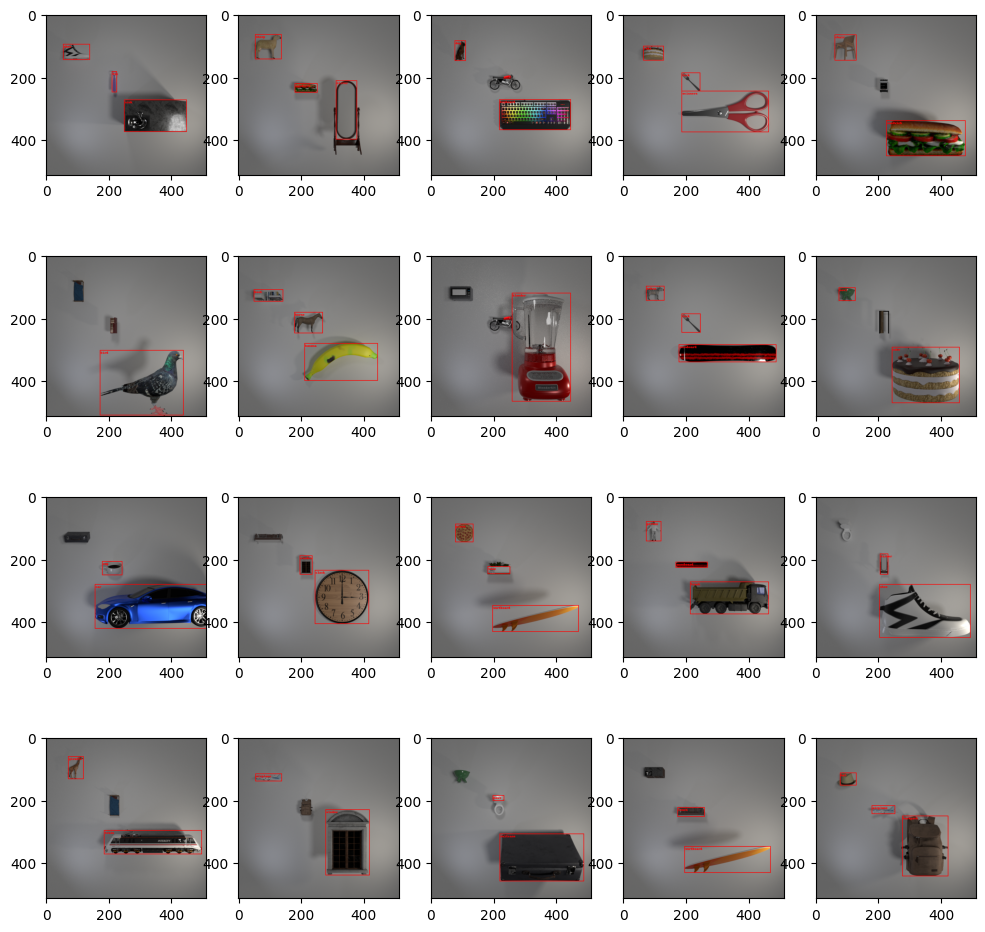

In [23]:
f, axarr = plt.subplots(4,5,figsize=(12, 12))
for i in range(20):
    x=i%5
    y=i//5
    axarr[y,x].imshow(new_image_list[i])
    